## Using various clustering methodologies to look at work place absenteeism

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

pd.options.display.max_columns = 40

First with Agglomerative Hierarchical Clustering (AHC) (Classification ascendante hiérarchique - CAH)

In [14]:
df_orig = pd.read_csv('Absenteeism_at_work_AAA/Absenteeism_at_work.csv', sep=';')
df_orig.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [16]:
#drop duplicates
df_orig.drop_duplicates(inplace=True)

In [21]:
#dropping some variables not wanted this time
df = df_orig.drop(['ID', 'Reason for absence', 'Seasons', 'Month of absence', 'Day of the week', 'Absenteeism time in hours'], axis=1)

#get dummier for edu
df = pd.get_dummies(df, columns=['Education'])

df.head()

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Education_1,Education_2,Education_3,Education_4
0,289,36,13,33,239.554,97,0,2,1,0,1,90,172,30,1,0,0,0
1,118,13,18,50,239.554,97,1,1,1,0,0,98,178,31,1,0,0,0
2,179,51,18,38,239.554,97,0,0,1,0,0,89,170,31,1,0,0,0
3,279,5,14,39,239.554,97,0,2,1,1,0,68,168,24,1,0,0,0
4,289,36,13,33,239.554,97,0,2,1,0,1,90,172,30,1,0,0,0


In [27]:
#scaling
sc = MinMaxScaler()
df_minmax = sc.fit_transform(df)

In [28]:
#making the link matrix
link_mat = linkage(df_minmax, method='ward', metric='euclidean')
link_mat

array([[   0.        ,    4.        ,    0.        ,    2.        ],
       [   2.        ,    5.        ,    0.        ,    2.        ],
       [  13.        ,  707.        ,    0.        ,    3.        ],
       ...,
       [1395.        , 1403.        ,   11.45758184,  120.        ],
       [1401.        , 1408.        ,   15.39013571,  300.        ],
       [1407.        , 1409.        ,   21.341099  ,  706.        ]])

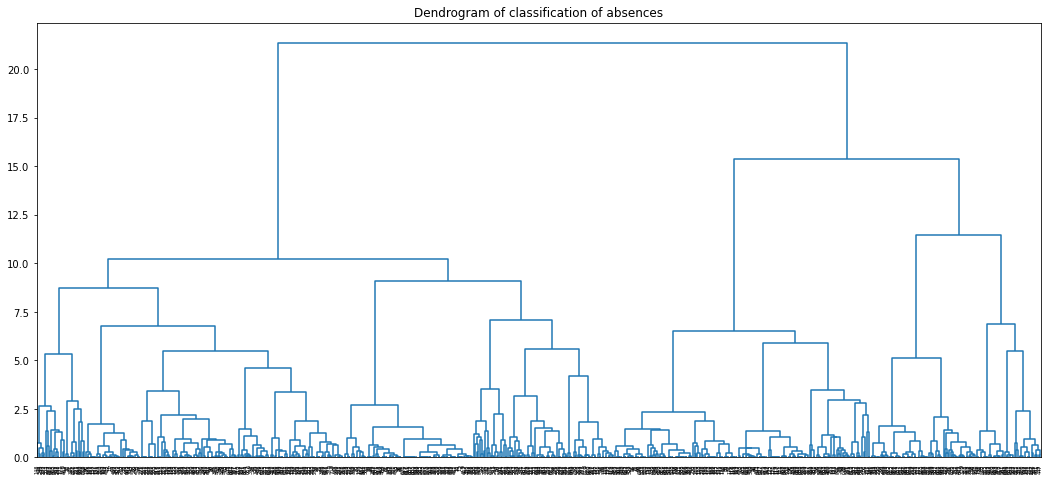

In [30]:
#making the dendogramme
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("Dendrogram of classification of absences")
dendrogram(link_mat, orientation='top', color_threshold=0);

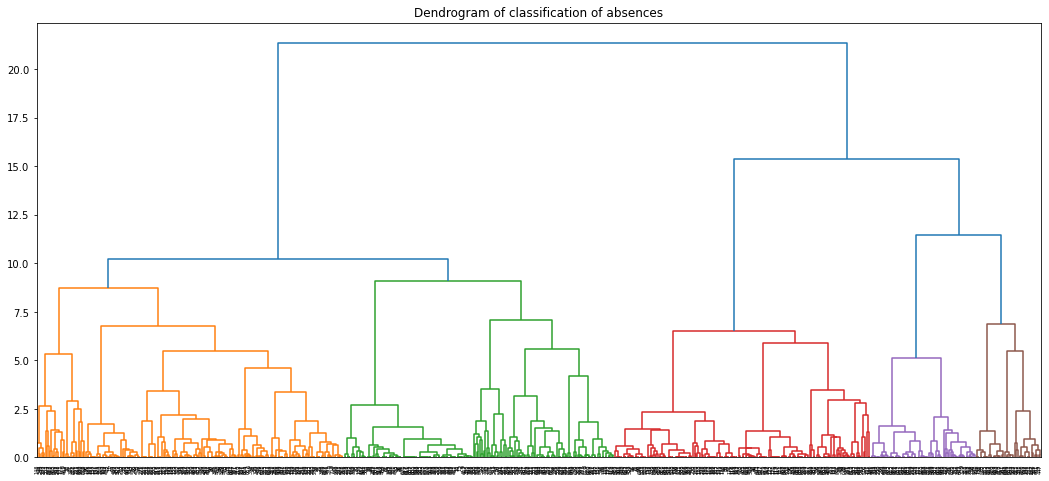

In [32]:
#changing the colour threshold to show 5 classes
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("Dendrogram of classification of absences")
dendrogram(link_mat, orientation='top', color_threshold=10);

In [33]:
#making the 5 classes
classes_cah = fcluster(link_mat, t=10, criterion='distance')
np.unique(classes_cah, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int32),
 array([216, 190, 180,  74,  46], dtype=int64))

In [34]:
#making the crosstable of reasons for absence on origial dataset
pd.crosstab(classes_cah, df_orig['Reason for absence'])

Reason for absence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,22,23,24,25,26,27,28
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9,4,0,1,1,0,1,6,1,2,9,4,1,16,10,2,0,0,5,21,0,25,31,3,2,14,0,48
2,25,2,0,0,0,2,2,0,0,0,5,7,2,18,3,0,0,0,5,6,2,1,35,0,4,11,24,36
3,5,3,0,0,1,1,4,6,3,2,7,9,2,7,5,0,0,0,4,9,0,4,57,0,12,4,12,23
4,1,5,0,0,0,0,1,2,0,0,1,2,2,13,1,0,1,0,3,1,2,4,15,0,6,2,11,1
5,3,2,1,0,0,0,0,1,2,0,3,4,1,1,0,0,2,1,4,3,2,3,4,0,7,2,0,0


#### Using PCA to reduce the dimensions

In [35]:
#standardise
df_std = StandardScaler().fit_transform(df)

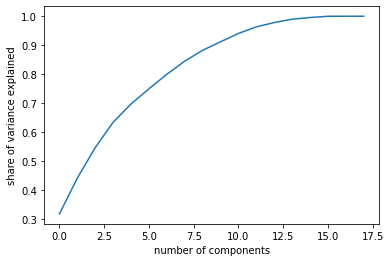

In [36]:
#apply PCA and plot
pca = PCA().fit(df_minmax)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('share of variance explained');

10 components explain about 90% of the variance

The variance explained by first 2 components is 0.4416921725560005


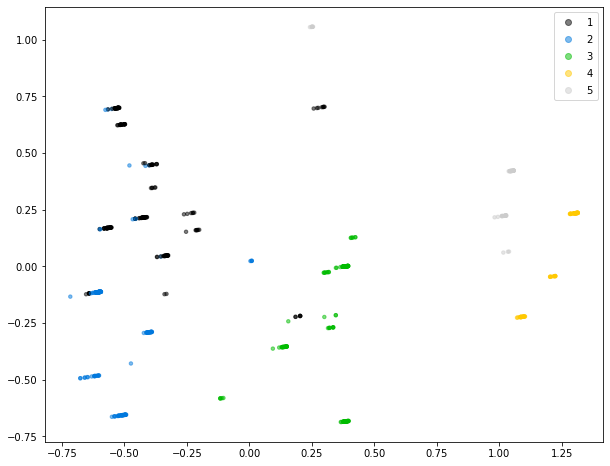

In [37]:
#get the projections
X_pca = pca.transform(df_minmax)

#plot the classes optained by first 2 components
plt.figure(figsize=(10,8))
scat = plt.scatter(X_pca[:,0], X_pca[:,1],
                   c=classes_cah, cmap=plt.cm.get_cmap('nipy_spectral'),
                   alpha=0.5, s=12)
plt.legend(*scat.legend_elements());

print(f"The variance explained by first 2 components is {pca.explained_variance_ratio_[:2].sum()}")

## K-means and DBSCAN

In [38]:
#scaling - trying the RobustScaler this time
df_rb = RobustScaler().fit_transform(df)

C:\Users\catri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


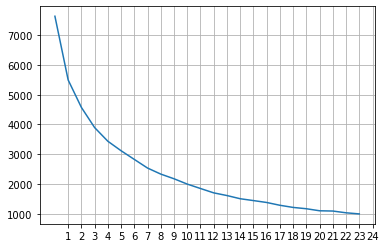

In [39]:
#choosing number of classes
inertias = []
for i in range(1,25):
    inertias.append(KMeans(n_clusters=i).fit(df_rb).inertia_)

plt.grid()
plt.plot(inertias)
plt.xticks(range(1,25));

Going to use 4 or 5 (even though not best on the graph) so it ties in with the PCA

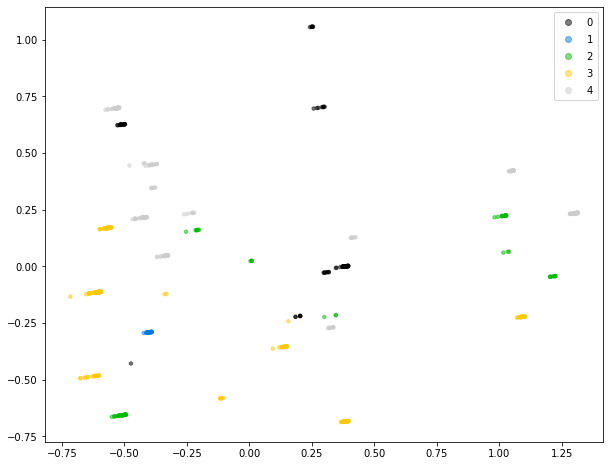

In [42]:
#the kmeans with the robustscaler data
classes_km_rb = KMeans(n_clusters=5).fit(df_rb).predict(df_rb)

#plot of the classes optained by first 2 components
plt.figure(figsize=(10,8))
scat = plt.scatter(X_pca[:,0], X_pca[:,1],
                   c=classes_km_rb, cmap=plt.cm.get_cmap('nipy_spectral'),
                   alpha=0.5, s=12)
plt.legend(*scat.legend_elements());

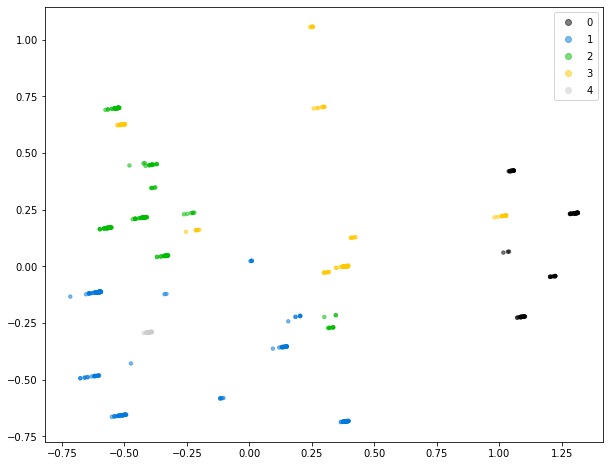

In [43]:
#kmeans with standardscaler
classes_km_std = KMeans(n_clusters=5).fit(df_std).predict(df_std)

#plot of the classes optained by first 2 components
plt.figure(figsize=(10,8))
scat = plt.scatter(X_pca[:,0], X_pca[:,1],
                   c=classes_km_std, cmap=plt.cm.get_cmap('nipy_spectral'),
                   alpha=0.5, s=12)
plt.legend(*scat.legend_elements());

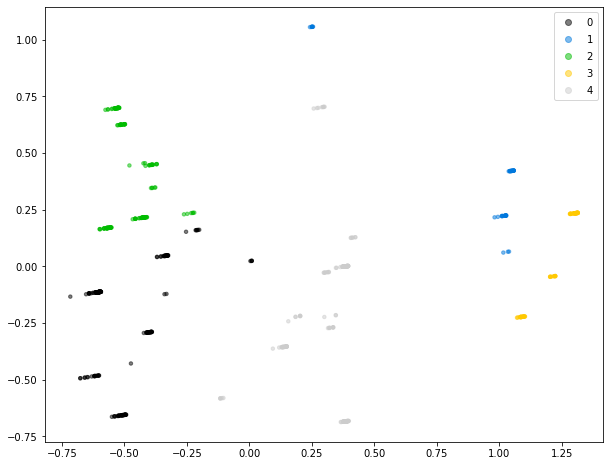

In [44]:
#kmeans on the PCA data
classes_km_pca = KMeans(n_clusters=5).fit(X_pca10).predict(X_pca10)

#plot of the classes optained by first 2 components
plt.figure(figsize=(10,8))
scat = plt.scatter(X_pca[:,0], X_pca[:,1],
                   c=classes_km_pca, cmap=plt.cm.get_cmap('nipy_spectral'),
                   alpha=0.5, s=12)
plt.legend(*scat.legend_elements());

DBSCAN

In [45]:
#make dataframe of the 3 types 
dist = pd.DataFrame(pdist(df_rb), columns=['df_rb'])
dist['df_std'] = pdist(df_std)
dist['pca'] = pdist(X_pca10)

dist.describe()

,df_rb,df_std,pca
count,248865.000000,248865.000000,248865.000000
mean,4.211841,5.661270,1.420129
std,1.983360,2.000274,0.508391
min,0.000000,0.000000,0.000000
25%,3.042085,4.383983,1.086439
50%,3.649325,5.660117,1.430932
75%,5.053955,6.839787,1.804009
max,12.863502,16.163548,2.731872


In [46]:
#inital dbscan
db = DBSCAN(eps=3, min_samples=15)
classes_db_pca = db.fit_predict(X_pca10)
np.unique(classes_db_pca)

array([0], dtype=int64)

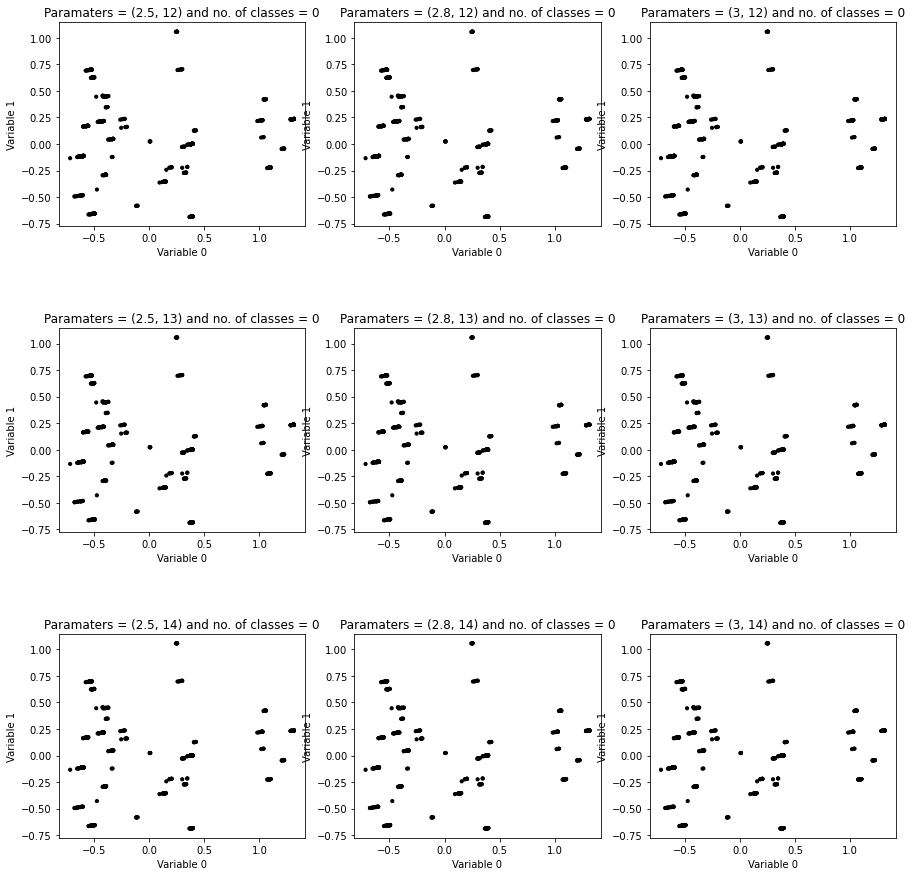

In [47]:
#looking for best parameters (to get 4 or 5 classes)

predicted_labels = []
params = []
for min_samples in [12, 13, 14]:
    for eps in [2.5, 2.8, 3]:
        db = DBSCAN(eps=eps ,min_samples=min_samples).fit(X_pca10)
        predicted_labels.append(db.labels_)
        params.append((eps, min_samples))

fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(len(params)):
    ax = fig.add_subplot(3,3,i+1)
    ax.scatter(X_pca[np.where(predicted_labels[i]!=-1), 0],
               X_pca[np.where(predicted_labels[i]!=-1), 1],
               c=predicted_labels[i][np.where(predicted_labels[i]!=-1)], s=10, cmap=plt.cm.get_cmap('nipy_spectral'))
    ax.set_xlabel("Variable 0")
    ax.set_ylabel("Variable 1")
    ax.set_title(f"Paramaters = {params[i]} and no. of classes = {len(np.unique(predicted_labels[i]))-1}")

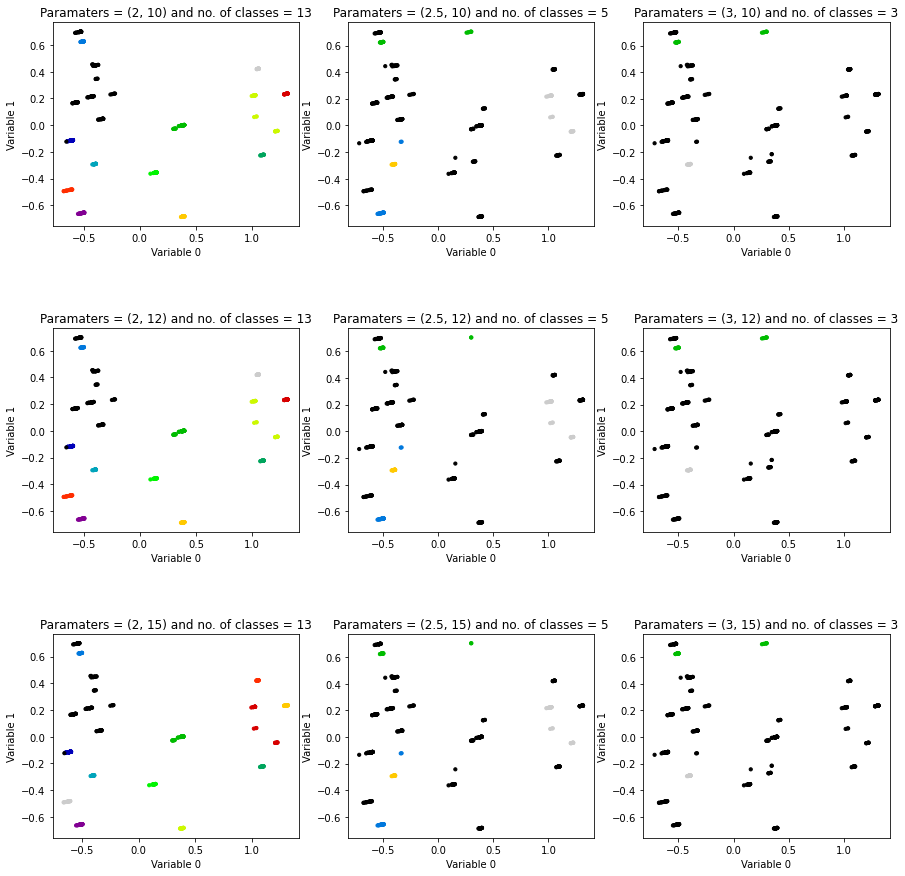

In [49]:
#dbscan for 4 classes with params 3,14
db = DBSCAN(eps=3, min_samples=15)
classes_db_pca = db.fit_predict(X_pca10)
np.unique(classes_db_pca)

#using with robust scaler data
predicted_labels = []
params = []
for min_samples in [10, 12, 15]:
    for eps in [2, 2.5, 3]:
        db = DBSCAN(eps=eps ,min_samples=min_samples).fit(df_rb)
        predicted_labels.append(db.labels_)
        params.append((eps, min_samples))

fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(len(params)):
    ax = fig.add_subplot(3,3,i+1)
    ax.scatter(X_pca[np.where(predicted_labels[i]!=-1), 0],
               X_pca[np.where(predicted_labels[i]!=-1), 1],
               c=predicted_labels[i][np.where(predicted_labels[i]!=-1)], s=10, cmap=plt.cm.get_cmap('nipy_spectral'))
    ax.set_xlabel("Variable 0")
    ax.set_ylabel("Variable 1")
    ax.set_title(f"Paramaters = {params[i]} and no. of classes = {len(np.unique(predicted_labels[i]))-1}")

In [50]:
#trying dbscan with 4 classes and params 2.5, 10
db = DBSCAN(eps=2.5, min_samples=10)
classes_db_rb = db.fit_predict(df_rb)
np.unique(classes_db_rb)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

Comparing the results vs AHC (cah)

In [51]:
pd.crosstab(classes_cah, classes_db_pca)

col_0,0
row_0,
1,216
2,190
3,180
4,74
5,46


In [52]:
pd.crosstab(classes_cah, classes_db_rb)

col_0,-1,0,1,2,3,4
row_0,,,,,,
1,13,170,2,31,0,0
2,5,122,34,0,29,0
3,8,172,0,0,0,0
4,0,64,0,0,0,10
5,7,20,0,0,0,19


In [53]:
pd.crosstab(classes_cah, classes_km_pca)

col_0,0,1,2,3,4
row_0,,,,,
1,42,0,160,0,14
2,180,0,10,0,0
3,0,0,0,0,180
4,0,0,0,74,0
5,0,46,0,0,0


In [54]:
pd.crosstab(classes_cah, classes_km_rb)

col_0,0,1,2,3,4
row_0,,,,,
1,37,0,7,46,126
2,1,29,38,113,9
3,83,0,3,80,14
4,0,0,10,23,41
5,7,0,19,0,20


In [55]:
pd.crosstab(classes_cah, classes_km_std)

col_0,0,1,2,3,4
row_0,,,,,
1,0,14,164,37,1
2,0,150,11,0,29
3,0,80,11,89,0
4,74,0,0,0,0
5,23,0,0,23,0


### Getting the characteristics of each class

In [56]:
#xith classes_km_std
df_orig.drop(['ID',
          'Reason for absence',
          'Seasons', 'Month of absence',
          'Day of the week'], axis=1).groupby(classes_km_std).mean().round(2)

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,200.80,20.12,11.70,34.02,268.31,95.29,0.02,2.76,0.65,0.00,0.21,0.24,67.70,171.97,22.79,5.64
1,172.98,30.66,15.61,41.39,266.54,94.40,0.07,1.05,0.51,0.65,0.03,0.35,90.39,170.94,31.07,5.50
2,281.80,32.68,12.81,37.87,273.62,93.83,0.08,1.00,1.97,0.94,0.06,0.48,73.23,170.36,25.11,9.88
3,259.54,32.19,7.28,28.84,275.95,94.98,0.05,1.15,0.92,0.24,0.09,2.32,71.85,172.01,24.12,5.62
4,155.07,12.50,13.73,33.83,300.82,95.67,0.00,1.00,1.93,1.00,0.03,0.00,94.33,195.63,24.90,15.97


Notes on the classes:
class 0: class with only occasional drinkers and a few smokers. Absences there are the longest: 13.2 hours on average. A high average number of children (1.65) and tall people but with a correct BMI...

class 1: class of the most qualified. No drinker or smoker. Absences almost never resulting from a disciplinary fault and the lowest average duration of absences compared to the other classes. BMI lower than average. Few animals and few children on average. Slightly younger average age.

class 2: majority of occasional drinkers, very few smokers. BMI and weight above average. The average distance from home to work is quite high and the absence results in 6% of cases from a lack of discipline. These absences are rather shorter in hours with an average of 6.56 hours. People older than average. Low degree level. Few children 0.49 children on average and a long average working time.

class 3: as for class 2, majority of occasional drinkers, very few smokers, high home-work distance. On the other hand, younger people, not overweight and with a relatively normal BMI. Average number of raised children (1.76) and pets too (1.35). Relatively high absence time in hours.

class 4: average level of diploma, with an average of 1.02 children. Class with more occasional smokers than the others and some occasional drinkers, with a fairly high average number of animals.

In [57]:
df_orig["ID"].groupby(classes_km_std).nunique()

0     5
1    12
2    10
3     9
4     2
Name: ID, dtype: int64

In [58]:
#with classes_db_rb
df_orig.drop(['ID',
          'Reason for absence',
          'Seasons', 'Month of absence',
          'Day of the week'], axis=1).groupby(classes_db_rb).mean().round(2)

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
-1,235.36,32.70,11.09,39.61,271.82,94.88,0.12,1.58,0.67,0.58,0.39,3.39,83.97,176.09,27.18,4.33
0,221.08,30.56,12.89,36.26,271.43,94.41,0.04,1.27,1.08,0.53,0.06,0.56,76.79,169.90,26.58,6.76
1,118.00,13.11,18.33,49.78,270.97,94.50,0.17,1.00,1.06,1.00,0.06,0.00,96.72,177.83,30.67,9.08
2,365.39,51.23,5.06,30.06,269.67,94.55,0.10,1.00,1.26,0.74,0.26,4.00,76.13,172.52,25.45,7.03
3,155.00,12.00,14.00,34.00,299.35,95.69,0.00,1.00,2.00,1.00,0.00,0.00,95.00,196.00,25.00,16.41
4,290.83,15.48,5.79,29.90,261.52,95.79,0.10,2.34,0.00,0.00,0.00,0.00,80.38,180.21,25.00,6.07


In [60]:
df_orig["ID"].groupby(classes_db_rb).nunique()

-1     7
 0    22
 1     2
 2     2
 3     1
 4     3
Name: ID, dtype: int64

Note 7 ppl no class

### Looking at length of absence

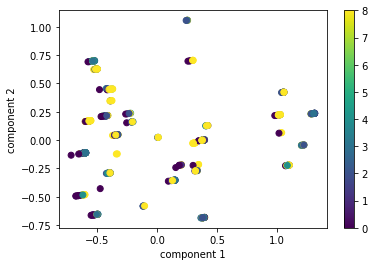

In [62]:
#for first 2 components
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=df_orig["Absenteeism time in hours"],
           vmin = 0, vmax = 8)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();